In [2]:
import pulp
import networkx as nx

# Data

In [3]:
sommets = [v for v in range(1,9)]
aretes = [(1, 2),(1, 3),(1, 7),(2, 3),(2, 4),(2, 5),(2, 7),(2, 8),(3, 4),(7, 6),(7, 8),(4, 5),(5, 6),(5, 8),(8, 6)]
poids = [6,7,4,4,9,9,10,5,4,12,11,6,8,7,14]
aretes = dict(zip(aretes,poids))

In [4]:
for (u,v) in aretes:
    print(u,";",v,";",aretes[(u,v)])

1 ; 2 ; 6
1 ; 3 ; 7
1 ; 7 ; 4
2 ; 3 ; 4
2 ; 4 ; 9
2 ; 5 ; 9
2 ; 7 ; 10
2 ; 8 ; 5
3 ; 4 ; 4
7 ; 6 ; 12
7 ; 8 ; 11
4 ; 5 ; 6
5 ; 6 ; 8
5 ; 8 ; 7
8 ; 6 ; 14


In [5]:
G=nx.Graph()
for (u,v) in aretes:
    G.add_edge(u,v,cost=aretes[(u,v)])

In [6]:
G.edges(data=True)

EdgeDataView([(1, 2, {'cost': 6}), (1, 3, {'cost': 7}), (1, 7, {'cost': 4}), (2, 3, {'cost': 4}), (2, 4, {'cost': 9}), (2, 5, {'cost': 9}), (2, 7, {'cost': 10}), (2, 8, {'cost': 5}), (3, 4, {'cost': 4}), (7, 6, {'cost': 12}), (7, 8, {'cost': 11}), (4, 5, {'cost': 6}), (5, 6, {'cost': 8}), (5, 8, {'cost': 7}), (8, 6, {'cost': 14})])

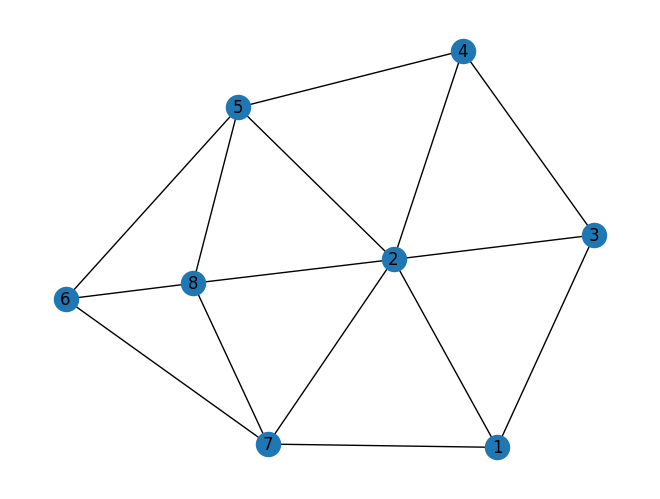

In [7]:
nx.draw(G,with_labels=True)

# Kruskal

In [8]:
T = nx.minimum_spanning_tree(G,weight="cost")

In [9]:
sorted(T.edges(data=True))

[(1, 2, {'cost': 6}),
 (1, 7, {'cost': 4}),
 (2, 3, {'cost': 4}),
 (2, 8, {'cost': 5}),
 (3, 4, {'cost': 4}),
 (4, 5, {'cost': 6}),
 (5, 6, {'cost': 8})]

In [10]:
sum(G[u][v]["cost"] for (u,v) in sorted(T.edges()))

37

# MIP1

In [11]:
# déclaration du problème
prob=pulp.LpProblem("tree",pulp.LpMinimize)

# variables
x=pulp.LpVariable.dicts("x",G.edges(),cat=pulp.LpBinary)

# objectif
prob += pulp.lpSum(x[(i,j)]*G[i][j]["cost"] for (i,j) in x)

# n-1 edges
prob += pulp.lpSum(x)==len(G.nodes())-1

# no cycles
for S in pulp.allcombinations(list(G.nodes()),len(G.nodes())):
    if len(S)>1:
        prob += pulp.lpSum(x[(u,v)] for u in S for v in S if (u,v) in x) <= len(S)-1

In [12]:
#for S in pulp.allcombinations(list(G.nodes()),len(G.nodes())):
#    if len(S)>2:
#        print(S,":",pulp.lpSum(x[(u,v)] for u in S for v in S if (u,v) in x),"<=", len(S)-1)

In [13]:
#prob

In [14]:
prob.solve()

1

In [15]:
pulp.value(prob.objective)

37.0

In [16]:
for (i,j) in x:
    if pulp.value(x[(i,j)])>0.9:
        print((i,j),G[i][j]["cost"])

(1, 2) 6
(1, 7) 4
(2, 3) 4
(2, 8) 5
(3, 4) 4
(4, 5) 6
(5, 6) 8


# MIP 2

In [17]:
H=G.to_directed()

In [18]:
H.edges(data=True)

OutEdgeDataView([(1, 2, {'cost': 6}), (1, 3, {'cost': 7}), (1, 7, {'cost': 4}), (2, 1, {'cost': 6}), (2, 3, {'cost': 4}), (2, 4, {'cost': 9}), (2, 5, {'cost': 9}), (2, 7, {'cost': 10}), (2, 8, {'cost': 5}), (3, 1, {'cost': 7}), (3, 2, {'cost': 4}), (3, 4, {'cost': 4}), (7, 1, {'cost': 4}), (7, 2, {'cost': 10}), (7, 6, {'cost': 12}), (7, 8, {'cost': 11}), (4, 2, {'cost': 9}), (4, 3, {'cost': 4}), (4, 5, {'cost': 6}), (5, 2, {'cost': 9}), (5, 4, {'cost': 6}), (5, 6, {'cost': 8}), (5, 8, {'cost': 7}), (8, 2, {'cost': 5}), (8, 7, {'cost': 11}), (8, 5, {'cost': 7}), (8, 6, {'cost': 14}), (6, 7, {'cost': 12}), (6, 5, {'cost': 8}), (6, 8, {'cost': 14})])

In [19]:
L=[]
for (u,v) in H.edges():
    if v==1:
        L.append((u,v))
H.remove_edges_from(L)

In [20]:
# déclaration du problème
prob=pulp.LpProblem("tree",pulp.LpMinimize)

# variables
x=pulp.LpVariable.dicts("x",H.edges(),cat=pulp.LpBinary)
u=pulp.LpVariable.dicts("u",H.nodes(),lowBound=0,upBound=len(H.nodes())-1,cat=pulp.LpInteger)

# objectif
prob += pulp.lpSum(x[(i,j)]*H[i][j]["cost"] for (i,j) in x)

prob += pulp.lpSum(x[(1,j)] for j in H.nodes() if (1,j) in x)>=1
for j in H.nodes():
    if j>1:
        prob += pulp.lpSum(x[(i,j)] for i in H.nodes() if (i,j) in x)==1
for (i,j) in H.edges():
    if j>1:
        prob += u[i]+1-u[j]<=len(H.nodes())*(1-x[(i,j)])

In [21]:
#prob

In [22]:
prob.solve()

1

In [23]:
pulp.value(prob.objective)

37.0

In [24]:
for (i,j) in x:
    if pulp.value(x[(i,j)])>0.9:
        print((i,j),H[i][j]["cost"])

(1, 2) 6
(1, 7) 4
(2, 3) 4
(2, 8) 5
(3, 4) 4
(4, 5) 6
(5, 6) 8


# MIP 3

In [25]:
# déclaration du problème
prob=pulp.LpProblem("tree",pulp.LpMinimize)

# variables
x=pulp.LpVariable.dicts("x",H.edges(),cat=pulp.LpBinary)
f=pulp.LpVariable.dicts("f",H.edges(),lowBound=0,upBound=None,cat=pulp.LpContinuous)

# objectif
prob += pulp.lpSum(x[(i,j)]*H[i][j]["cost"] for (i,j) in x)

# optional
#prob += pulp.lpSum(x)==len(H.nodes())-1

prob += pulp.lpSum(f[(1,j)] for j in H.nodes() if (1,j) in f)==len(H.nodes())-1
for j in H.nodes():
    if j>1:
        prob += pulp.lpSum(f[(i,j)] for i in H.nodes() if (i,j) in f)==pulp.lpSum(f[(j,i)] for i in H.nodes() if (j,i) in f)+1
for (i,j) in H.edges():
    prob +=f[(i,j)]<=(len(H.nodes())-1)*(x[(i,j)])

In [26]:
prob.solve()

1

In [27]:
prob

tree:
MINIMIZE
6*x_(1,_2) + 7*x_(1,_3) + 4*x_(1,_7) + 4*x_(2,_3) + 9*x_(2,_4) + 9*x_(2,_5) + 10*x_(2,_7) + 5*x_(2,_8) + 4*x_(3,_2) + 4*x_(3,_4) + 9*x_(4,_2) + 4*x_(4,_3) + 6*x_(4,_5) + 9*x_(5,_2) + 6*x_(5,_4) + 8*x_(5,_6) + 7*x_(5,_8) + 8*x_(6,_5) + 12*x_(6,_7) + 14*x_(6,_8) + 10*x_(7,_2) + 12*x_(7,_6) + 11*x_(7,_8) + 5*x_(8,_2) + 7*x_(8,_5) + 14*x_(8,_6) + 11*x_(8,_7) + 0
SUBJECT TO
_C1: f_(1,_2) + f_(1,_3) + f_(1,_7) = 7

_C2: f_(1,_2) - f_(2,_3) - f_(2,_4) - f_(2,_5) - f_(2,_7) - f_(2,_8)
 + f_(3,_2) + f_(4,_2) + f_(5,_2) + f_(7,_2) + f_(8,_2) = 1

_C3: f_(1,_3) + f_(2,_3) - f_(3,_2) - f_(3,_4) + f_(4,_3) = 1

_C4: f_(1,_7) + f_(2,_7) + f_(6,_7) - f_(7,_2) - f_(7,_6) - f_(7,_8)
 + f_(8,_7) = 1

_C5: f_(2,_4) + f_(3,_4) - f_(4,_2) - f_(4,_3) - f_(4,_5) + f_(5,_4) = 1

_C6: f_(2,_5) + f_(4,_5) - f_(5,_2) - f_(5,_4) - f_(5,_6) - f_(5,_8)
 + f_(6,_5) + f_(8,_5) = 1

_C7: f_(2,_8) + f_(5,_8) + f_(6,_8) + f_(7,_8) - f_(8,_2) - f_(8,_5)
 - f_(8,_6) - f_(8,_7) = 1

_C8: f_(5,_6) - f_(6,_5) 

In [28]:
pulp.value(prob.objective)

37.0

In [29]:
for (i,j) in x:
    if pulp.value(x[(i,j)])>0.9:
        print((i,j),H[i][j]["cost"])

(1, 2) 6
(1, 7) 4
(2, 3) 4
(2, 8) 5
(3, 4) 4
(4, 5) 6
(5, 6) 8


# MIP 4 (for planar graphs only)

In [30]:
G_dual = nx.Graph()

In [31]:
dual_edges = [("a","b"),("a","i"),("b","i"),("a","d"),("b","c"),("c","d"),("e","d"),
             ("f","c"),("e","h"),("g","h"),("f","g"),("e","i"),("f","i"),("h","i"),("g","i")]
primal_edges = [(6,8),(5,6),(6,7),(5,8),(7,8),(2,8),(2,5),
               (2,7),(2,4),(2,3),(1,2),(4,5),(1,7),(3,4),(1,3)]
intersection = dict(zip(dual_edges,primal_edges))

In [32]:
for (u,v) in dual_edges:
    G_dual.add_edge(u,v,primal_edge=intersection[(u,v)])

In [33]:
H=G.to_directed()

In [34]:
L=[]
for (u,v) in H.edges():
    if v==8:
        L.append((v,u))
H.remove_edges_from(L)

In [35]:
H_dual=G_dual.to_directed()
L=[]
for (u,v) in H.edges():
    if v=="i":
        L.append((v,u))
H_dual.remove_edges_from(L)

In [36]:
#H_dual.edges(data=True)

In [37]:
# déclaration du problème
prob=pulp.LpProblem("tree",pulp.LpMinimize)

# variables
x=pulp.LpVariable.dicts("x",H.edges(),cat=pulp.LpBinary)
y=pulp.LpVariable.dicts("y",H_dual.edges(),cat=pulp.LpBinary)

# objectif
prob += pulp.lpSum(x[(i,j)]*H[i][j]["cost"] for (i,j) in x)

# connectivity
for i in H.nodes():
    if i!=8:
        prob += pulp.lpSum(x[(i,j)] for j in H.nodes() if (i,j) in x)==1, "node_%s"%i
for i in H_dual.nodes():
    if i !="i":
        prob += pulp.lpSum(y[(i,j)] for j in H_dual.nodes() if (i,j) in y)==1, "node_%s"%i

# partition
for (i,j) in H_dual.edges():
    (k,l) = H_dual[i][j]["primal_edge"]
    if (k,l) in x and (l,k) in x and (i,j) in y and (j,i) in y:
        prob += y[(i,j)]+y[(j,i)] + x[(k,l)]+x[(l,k)] == 1

In [38]:
#prob

In [39]:
prob.solve()

1

In [40]:
pulp.value(prob.objective)

37.0